## Кластеризация и уменьшение размерности

Ранее мы рассматривали методы обучения с учителем, где для каждого элемента входных данных было задано ожидаемое значение целевой функции. Однако в некоторых случаях можно обойтись без целевой функции, используя некоторые свойства самого датасета. В этом случае говорят об **обучении без учителя**.

Рассмотрим снова датасет изображений рукописных цифр [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)):

In [ ]:
import sklearn as sk
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

mnist = fetch_openml('mnist_784')

X = mnist.data.to_numpy()/255.0
Y = mnist.target.to_numpy().astype(np.uint8)
print(X.shape, Y.shape)

Мы можем использовать свойста **близости** изображений цифр, чтобы реализовать алгоритм классификации.

### KNN классификаторы

Алгоритм **k ближайших соседей** (*K nearest neighbors*) используется в том случае, если на множестве есть некоторая метрика близости. Для цифр метрикой близости можно считать, например, среднеквадратичную разность между яркостями всех пикселей изображения:

In [ ]:
def dist(X,Y):
    return np.sum((X-Y)*(X-Y))

for _ in range(15):
    i,j = np.random.randint(0,len(X),size=2)
    print(f"Distance between {Y[i]} and {Y[j]} is {dist(X[i],X[j])}")

Вы можете запустить этот код несколько раз, он считает расстояние между изображениями случайных цифр. Можно заметить, что расстояния между изображениями одних и тех же цифр стабильно меньше.

Исходя из этого, можно предложить следующий алгоритм классификации входного изображения $I$:

1. Ищем такое изображение $X_i$ из нашего обучающего датасета, что $\mathrm{dist}(X_i,I)\to\min$.
2. В качестве ответа возвращаем метку этого изображения $Y_i$.

> Используем для ускорения работы обучающий датасет из 10000 изображений. Вы можете посмотреть, как программа работает на полном датасете, но приготовьтесь ждать

In [9]:
X_train, X_test, Y_train, Y_test = \
   sk.model_selection.train_test_split(X,Y,train_size=10000, test_size=2000)

def classify(input_img):
    i = np.argmin([dist(x,input_img) for x in X_train])
    return Y_train[i]

n = 20
correct = 0
for x,y in zip(X_test[:n],Y_test[:n]):
    r = classify(x)
    print(f"{y} classified as {r}")
    correct += (y==r)
print(f"Accuracy: {correct/n}")
    

6 classified as 6
3 classified as 3
2 classified as 2
3 classified as 3
3 classified as 3
8 classified as 8
8 classified as 8
5 classified as 5
9 classified as 7
2 classified as 2
2 classified as 2
8 classified as 8
1 classified as 1
5 classified as 5
4 classified as 4
8 classified as 6
1 classified as 1
5 classified as 5
1 classified as 1
1 classified as 1
Accuracy: 0.9


Нам удалось реализовать классификатор в несколько строчек кода! Это классификатор KNN при K=1.

Для повышения точности можно предложить следующий алгоритм:

1. Выбираем K ближайших по расстоянию цифр к I
2. Из этого множества возвращаем цифру, которая встречается наибольшее число раз

Например, если три ближайшие цифры будут {8,3,3}, то будет возвращено значение 3.

KNN-классификатор также включен в состав библиотеки Scikit Learn:

In [10]:
import sklearn.neighbors

res=[]
for i in range(1,10):
    model = sk.neighbors.KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train,Y_train)
    acc = sk.metrics.accuracy_score(Y_test,model.predict(X_test))
    print(f"Accuracy for k={i} is {acc}")
    res.append(acc)

Accuracy for k=1 is 0.9555
Accuracy for k=2 is 0.9435
Accuracy for k=3 is 0.9455
Accuracy for k=4 is 0.9435
Accuracy for k=5 is 0.944
Accuracy for k=6 is 0.943
Accuracy for k=7 is 0.945
Accuracy for k=8 is 0.943
Accuracy for k=9 is 0.941


Можно заметить, что для некоторого k наблюдается оптимальное значение точности. Поэтому, чтобы получить оптимальную модель для нашего датасета, нужно перебрать несколько значений k. Такая оптимизация называется **оптимизацией гиперпараметров**.

При оптимизации гиперпараметров, чтобы померить "честную" точность модели, нельзя использовать ту же тестовую выборку, что и при оптимизации. Поэтому в таком случае выборку разделяют на три части:
* **Обучающая** используется при обучении моделей
* **Валидационная** используется при оптимизации гиперпараметров
* **Тестовая** используется при финальном тестировании модели

In [ ]:
plt.plot(res)
plt.show()

### Кластеризация. Метод k-средних

В случае с KNN мы решали задачу классификации - хотя и ориентировались в первую очередь на расстояния между объектами в пространстве признаков. Но мы можем поставить и другую задачу - как разбить оптимальным образом все изображения цифр в пространстве признаков на некоторые группы? Это и будет **задача кластеризации**, при этом нам не нужно знать, какие цифры соответствуют изображениям.

Наиболее известный алгоритм кластеризации - это алгоритм **k-средних**. Предположим, мы хотим разбить исходное множество объектов $X$ на $k$ непересекающихся кластеров $X_i$, так, чтобы $\bigcup\limits_i X_i = X$ и $X_i\cap X_j=\emptyset$ для $i\neq j$, и чтобы расстояние между объектами в кластерах было минимальным.

Последнее требование может быть заменено требованием, чтобы суммарное расстояние от всех точек кластера $X_i$ до его **центра масс** $c_i$ было минимальным для всех кластеров, т.е.
\begin{equation}
\sum_{i=1}^k \sum_{x\in S_i} (x-c_i)^2 \to \min
\end{equation}

Алгоритм k-средних является итерационным алгоритмом. Изначально центры масс выбираются случайным образом, после чего на каждом шаге происходит перевычисление центров масс и перегруппировка точек внутри кластеров. Алгоритм завершается, когда на очередной шаг не приводит к изменению кластеров.

Используем K-Means для группировки всех изображений рукописных символов на кластеры:

In [11]:
import sklearn.cluster

model = sk.cluster.KMeans(n_clusters=10).fit(X)

В процессе кластеризации вычисляются также значения **центроидов** кластеров. Посмотрим на них:

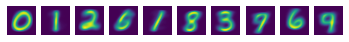

In [12]:
fig,ax = plt.subplots(1,10)
for i,im in enumerate(model.cluster_centers_):
    ax[i].imshow(im.reshape(28,28))
    ax[i].axis('off')
plt.show()

In [13]:
model.labels_

array([5, 0, 9, ..., 7, 3, 8])

Мы видим, что центроиды более-менее соответствуют цифрам, при этом мы сгруппировали похожие символы вместе без какой-либо предварительной разметки. Однако вполне вероятна ситуация, когда какой-то цифре будет соответствовать несколько кластеров, а изображения каких-то двух похожих цифр попадут в один кластер. Это происходит из-за того, что метод k-средних не гарантирует нам получения **глобального минимума** расстояния в формуле (1), а только достижения **локального минимума**.

Для интереса, посмотрим на содержимое одного из кластеров (можете установить значение переменной `c` в соответствии с номером кластера, который хочется исследовать):

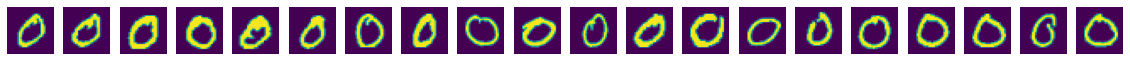

In [15]:
c = 0
res = [ x for x,l in zip(X,model.labels_) if l==c]

fig,ax = plt.subplots(1,20,figsize=(20,5))
for i,im in enumerate(res[:20]):
    ax[i].imshow(im.reshape(28,28))
    ax[i].axis('off')
plt.show()

Чтобы понять подробнее, как работает код выше, посмотрим на значение метода `labels_`:

In [ ]:
print(f"Размер вектора: {model.labels_.shape}")
print(model.labels_[:10])

В этом векторе для каждого элемента из исходного множества $X$ содержится номер соответствующего кластера. По сути дела, имея такие метки мы практически решили задачу классификации - надо лишь установить соответствие номера кластера и цифры. И, по всей видимости, подобрать параметры модели кластеризации, чтобы добиться наилучшего разбиения цифр на кластеры.

## Понижение размерности

Метод k-means разбивает наши цифры на кластеры, но при этом наблюдать за этим процессом визуально не представляется возможным, поскольку каждая цифра представляется некоторой точкой в пространстве размерности 784. Для визуального наблюдения за кластеризацией на бы хотелось как-то спроецировать картинку на двумерное пространство.

Такой процесс называется **понижением размерности**. Наиболее известный алгоритм понижения размерности - **[метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82)** (PCA, *Principal Component Analysis*).

Основная идея метода состоит в следующем. Представим себе некоторое множество точек на плоскости размерности 2. Если мы хотим снизить размерность до 1, то это означает, что мы применяем к исходным точкам некоторое преобразование. Например, мы можем смотреть на эти точки под разными углами, проецируя их на прямую. Для того, чтобы "разглядеть" точки получше, нам нужно выбрать такую проекцию, которая будет максимизировать разброс между точками.

Имея произвольное пространство размерности $n$, мы ищем такое направление (которое называется **главной компонентой**), проекция на которое даёт нам пространство размерности $n-1$, в котором разборос точек максимален. Далее мы повторяем процесс, пока не получим пространство необходимой размерности.

Посмотрим, что даёт метод PCA применительно к нашему датасету:

In [16]:
import sklearn.decomposition

X = mnist.data.to_numpy()/255.0

X2 = sk.decomposition.PCA(n_components=2).fit_transform(X)
X2[:10]

array([[ 0.47943618, -1.24005119],
       [ 3.96272385, -1.13713458],
       [-0.23135379,  1.54401998],
       [-3.12535132, -2.38198645],
       [-1.53458688,  2.86187001],
       [ 0.72928542,  0.87781825],
       [-2.8646583 , -0.63525889],
       [ 1.97445926, -1.21064152],
       [-3.42962283, -0.33058987],
       [-1.19222543,  1.81794168]])

Мы получили набор векторов размерности 2, соответствующих нашим исходным рукописным цифрам. Поскольку мы знаем принадлежность цифр различным классам, можем построить эти точки на плоскости и посмотреть, насколько действительно одинаковые цифры оказалиcь близко после PCA-преобразования:

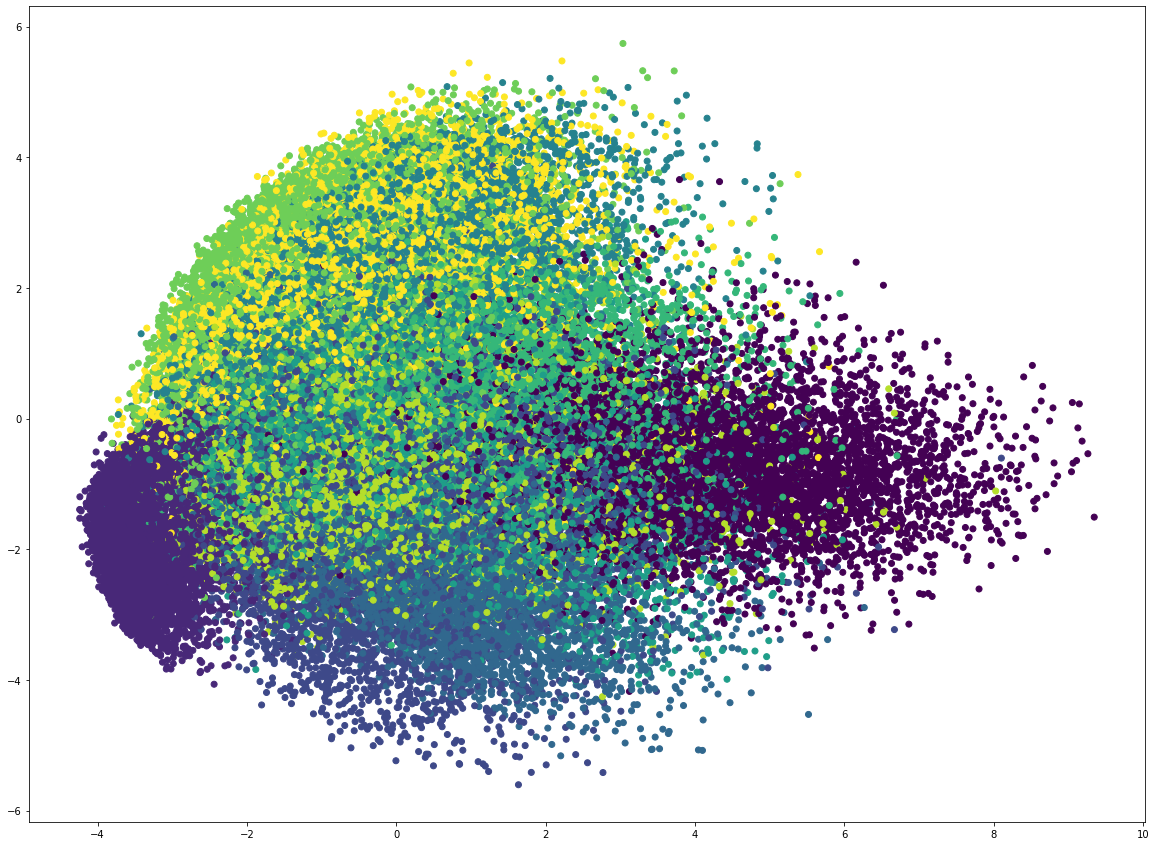

In [17]:
plt.figure(figsize=(20,15))
plt.scatter(X2[:,0],X2[:,1],c=Y)
plt.show()

В целом видно, что одинаковые классы оказываются сгруппированы в похожие кластеры, но при этом есть похожие и непохожие цифры. Посмотрим, как выглядит этот график для цифр 0 и 1:

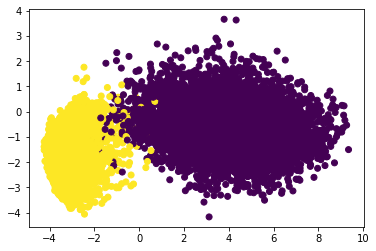

In [18]:
def plot_subset(s):
    tX = np.array([x for x,c in zip(X2,Y) if c in s])
    col = np.array([c for c in Y if c in s])
    plt.scatter(tX[:,0],tX[:,1],c=col)
    plt.show()

plot_subset({0,1})

Видим, что цифры хорошо различимы. Если бы мы применяли логистическую регрессию для классификации, никаких проблем бы не возникло!

Посмотрим теперь на более "похожие" цифры:

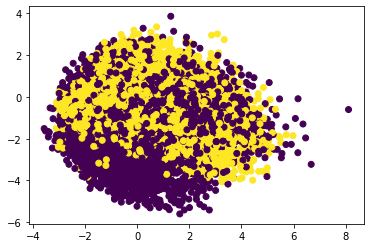

In [19]:
plot_subset({2,5})

Эти цифры уже существенно более "запутаны", и очевидно с их классификацией могут возникнуть проблемы.

Методы снижения размерности оказываются очень полезны для визуализации многомерных данных, чтобы понять, являются ли действительно классы разделимыми. Если мы сталкиваемся с какой-то задачей классификации или кластеризации, можно предварительно провести исследование данных за счет снижения размерности.